### Kernel Density Estimation

In [12]:
from Utilities.utils import read_data

In [13]:
url = 'https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt'
raw, _ = read_data(url)

c:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\ML\GammaRayBursts\Utilities\utils.py:21: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  raw = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [14]:
fluence, fluence_err = zip(*[(float(a), float(b)) for a, b in zip(raw[9], raw[10]) 
                                           if a != '-999' and b != '-999' 
                                           and float(b)!=0 and float(a)!=0] )

In [15]:
import numpy as np

In [16]:
erg_to_KeV = 624150907446.1*1e-3

In [17]:
fluence = np.log10(np.array(fluence)*erg_to_KeV)

In [18]:
import matplotlib.pyplot as plt
from Utilities import plot_settings

Text(0, 0.5, 'Density')

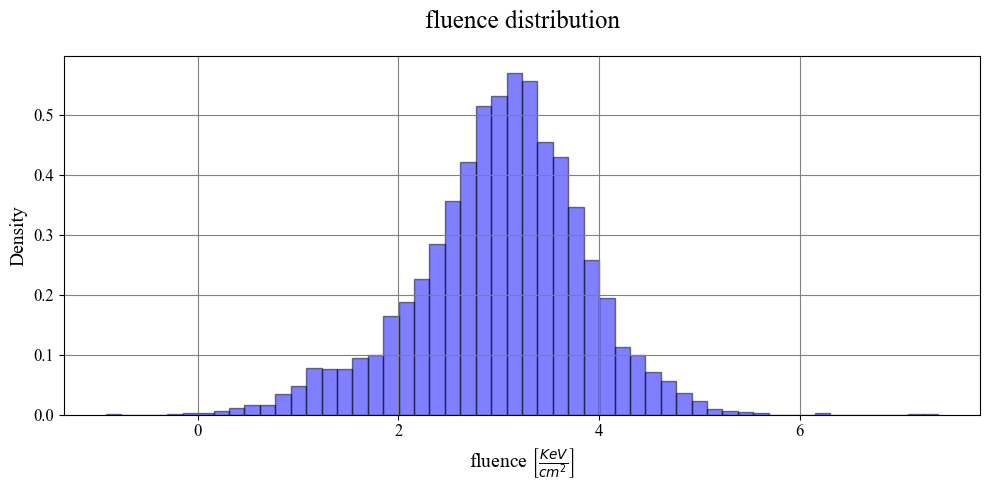

In [19]:
fluencec, fluenceb, _ = plt.hist(fluence, bins='scott', density=True, 
                         histtype='barstacked', edgecolor='black', color='blue', alpha=0.5) 
plt.title('fluence distribution')
plt.xlabel(r'fluence $\left[\frac{KeV}{cm^2}\right]$')
plt.ylabel('Density')

In [20]:
from sklearn.neighbors import KernelDensity

In [21]:
import numpy as np

In [22]:
X = fluence.reshape((-1,1))

In [23]:
bandwidths = np.linspace(0.1,1,10)

In [24]:
from Utilities.utils import KDE_LOO, cross_validation_LOO

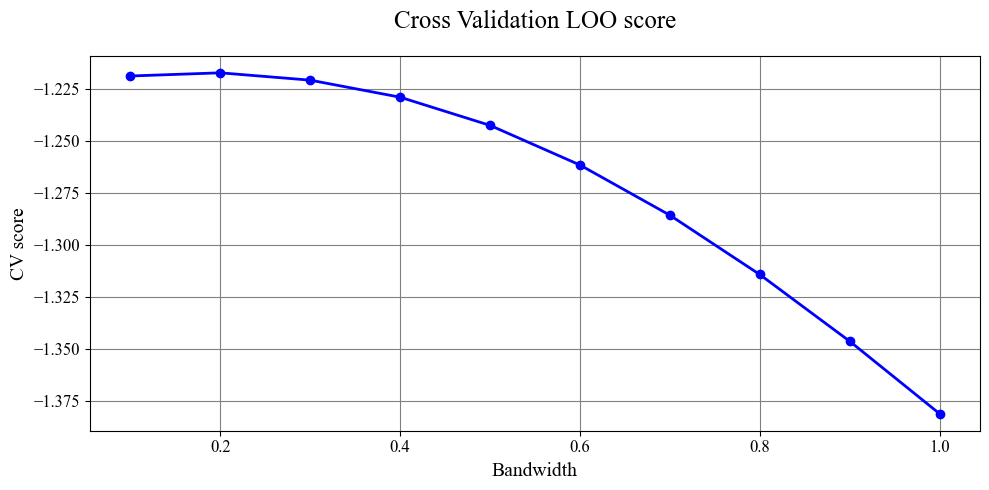

In [25]:
scores, best, best_bw = cross_validation_LOO(X, bandwidths, True)

In [26]:
xgrid = np.linspace(np.array(fluence).min(), np.array(fluence).max(),1000)

def kde_sklearn(data, bandwidth, kernel="gaussian"):
    kde_skl = KernelDensity(bandwidth = bandwidth, kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf), kde_skl

In [27]:
pdf, kde = kde_sklearn(np.array(fluence), bandwidths[best_bw])

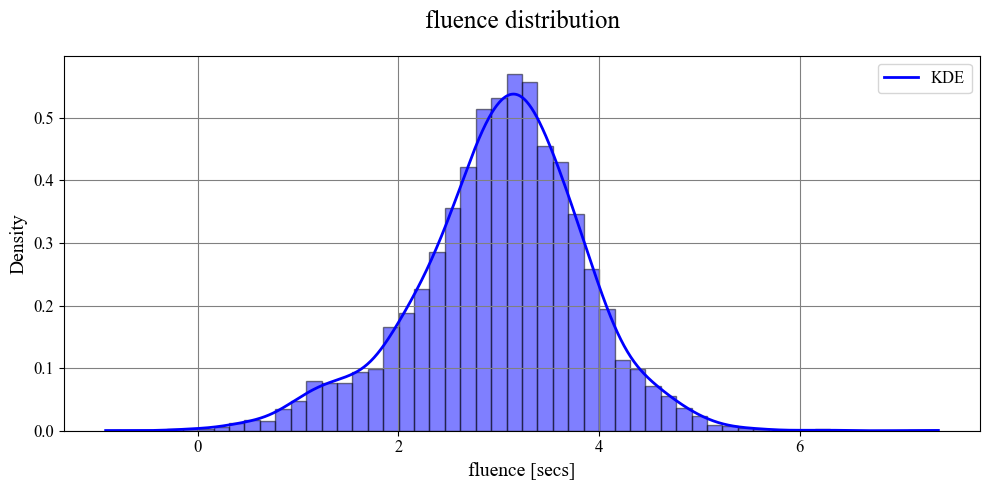

In [28]:
plt.plot(xgrid, pdf, color='blue', linewidth=2, label='KDE')
counts, bins, _ = plt.hist(fluence, bins='scott', density=True, histtype='barstacked', edgecolor='black', color='blue', alpha=0.5) 
plt.title('fluence distribution')
plt.xlabel('fluence [secs]')
plt.ylabel('Density')
plt.legend()

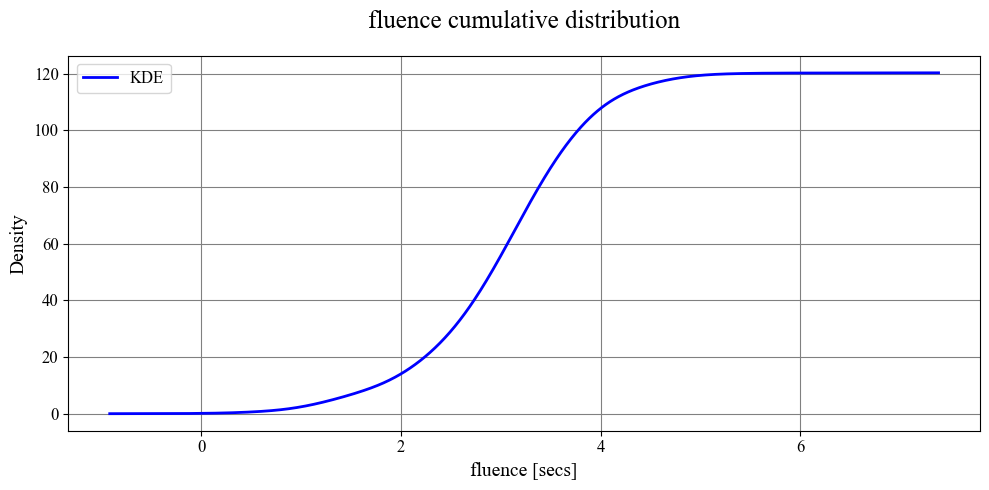

In [29]:
plt.plot(xgrid, np.cumsum(pdf), color='blue', linewidth=2, label='KDE')
plt.title('fluence cumulative distribution')
plt.xlabel('fluence [secs]')
plt.ylabel('Density')
plt.legend()

In [30]:
import scipy.stats

In [31]:
print('fluence Mean: ',fluence.mean())
print('fluence Std: ', fluence.std())
print('fluence mode:', scipy.stats.mode(fluence).mode)
print('fluence max: ', fluence.max())
print('fluence min: ', fluence.min())

fluence Mean:  3.0137537789781437
fluence Std:  0.8357049633305809
fluence mode: 2.2102629542358487
fluence max:  7.384524098680535
fluence min:  -0.9187707139231828


## Gaussian Mixture

In [32]:
from sklearn.mixture import GaussianMixture

In [33]:
ns = np.arange(1,20,1)

In [34]:
aic = np.zeros_like(ns)
bic = np.zeros_like(ns)
for n in ns:
    GM = GaussianMixture(n_components=n)
    GM.fit(X)
    aic[n-min(ns)] = GM.aic(X)
    bic[n-min(ns)] = GM.bic(X)

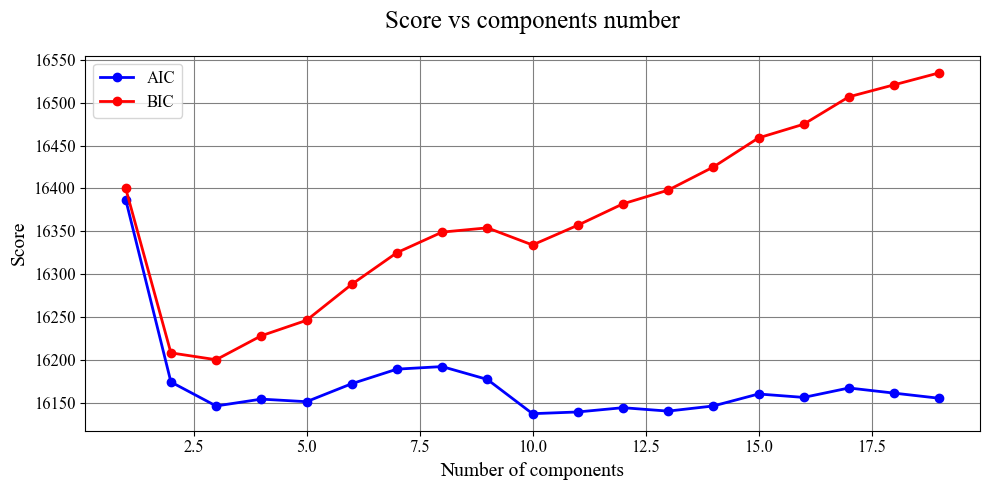

In [35]:
plt.plot(ns, aic, marker='o', color='blue', linewidth=2, label='AIC')
plt.plot(ns, bic, marker='o', color='red', linewidth=2, label='BIC')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('Score vs components number')
plt.legend()

In [36]:
GM = GaussianMixture(n_components=3)
GM.fit(X)

GaussianMixture(n_components=3)

In [37]:
x = np.linspace(X.min() - 0.5, X.max() + 0.5, 1000).reshape(-1, 1)

In [38]:
from scipy.stats import norm

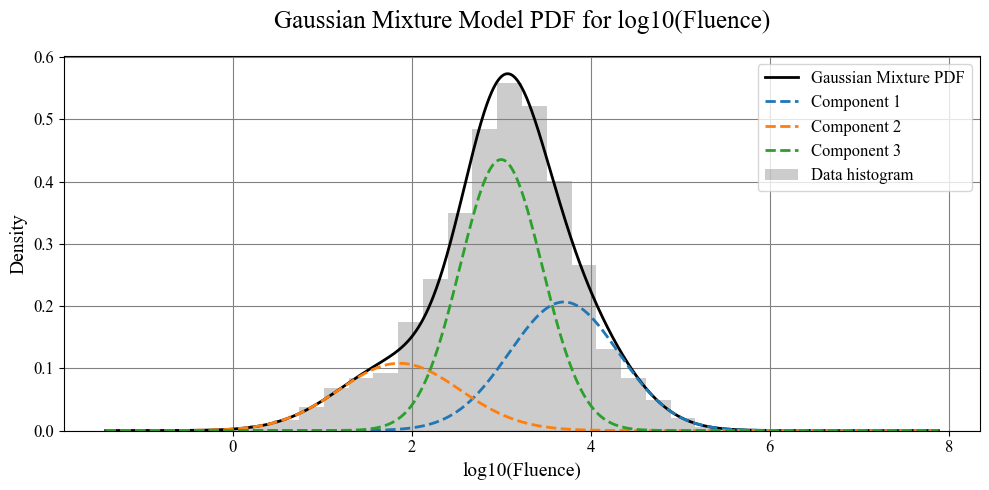

In [48]:
# Compute the weighted sum of PDFs from each Gaussian component
logprob = GM.score_samples(x)
pdf = np.exp(logprob)

# Plot the overall PDF
plt.plot(x, pdf, label='Gaussian Mixture PDF', color='black')

normals = []

# Optionally plot the individual Gaussians
for i in range(GM.n_components):
    mean = GM.means_[i, 0]
    std = np.sqrt(GM.covariances_[i, 0, 0])
    weight = GM.weights_[i]
    component_pdf = weight * norm.pdf(x, mean, std)
    plt.plot(x, component_pdf, '--', label=f'Component {i+1}')
    normals.append(component_pdf)

# Add original data histogram for context
plt.hist(X, bins=30, density=True, alpha=0.4, color='gray', label='Data histogram')

plt.xlabel('log10(Fluence)')
plt.ylabel('Density')
plt.title('Gaussian Mixture Model PDF for log10(Fluence)')
plt.legend()

In [40]:
for i in range(GM.n_components):
    print(f'Fluence Centroid {i}: {np.power(10,GM.means_[i, 0]):.3} +/- {np.sqrt(GM.covariances_[i, 0, 0])*np.power(10,GM.means_[i, 0]):.3} KeV/cm^2')

Fluence Centroid 0: 5.03e+03 +/- 3.07e+03 KeV/cm^2
Fluence Centroid 1: 73.0 +/- 49.3 KeV/cm^2
Fluence Centroid 2: 9.99e+02 +/- 4.58e+02 KeV/cm^2


Compute intersection points (Thresholds)

In [53]:
from scipy.optimize import brentq

In [71]:
pdf1 = lambda x: GM.weights_[0] * norm.pdf(x, GM.means_[0, 0], np.sqrt(GM.covariances_[0, 0, 0]))
pdf2 = lambda x: GM.weights_[1] * norm.pdf(x, GM.means_[1, 0], np.sqrt(GM.covariances_[1, 0, 0]))
pdf3 = lambda x: GM.weights_[2] * norm.pdf(x, GM.means_[2, 0], np.sqrt(GM.covariances_[2, 0, 0]))

In [93]:
diff12 = lambda x: pdf1(x) - pdf2(x)
diff23 = lambda x: pdf2(x) - pdf3(x)
diff02 = lambda x: pdf1(x) - pdf3(x)

In [95]:
threshold_23 = brentq(diff12, GM.means_[0, 0], GM.means_[1, 0])
threshold_12 = brentq(diff23, GM.means_[1, 0], GM.means_[2, 0])
threshold_02 = brentq(diff02, GM.means_[0, 0], GM.means_[2, 0])

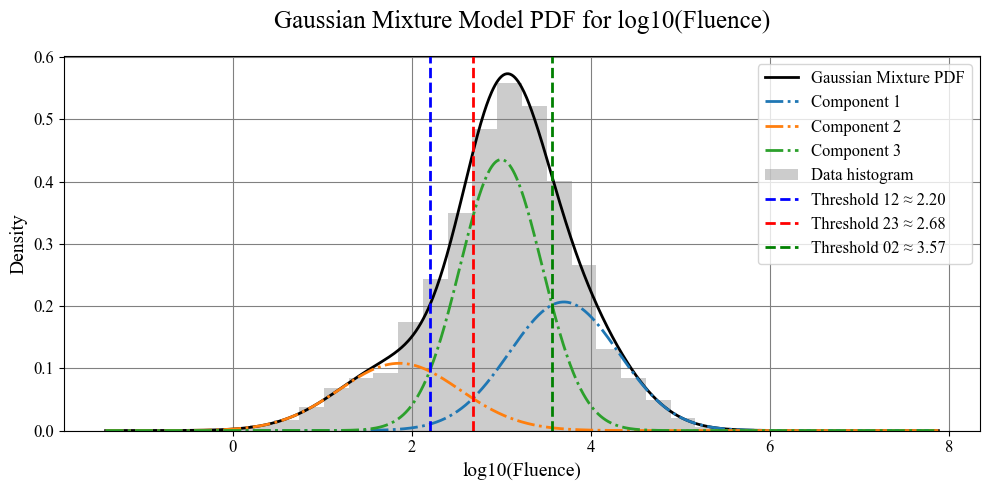

In [99]:
plt.plot(x, pdf, label='Gaussian Mixture PDF', color='black')

# Optionally plot the individual Gaussians
for i in range(GM.n_components):
    mean = GM.means_[i, 0]
    std = np.sqrt(GM.covariances_[i, 0, 0])
    weight = GM.weights_[i]
    component_pdf = weight * norm.pdf(x, mean, std)
    plt.plot(x, component_pdf, '-.', label=f'Component {i+1}')

# Add original data histogram for context
plt.hist(X, bins=30, density=True, alpha=0.4, color='gray', label='Data histogram')
plt.axvline(threshold_12, color='blue', linestyle='--', label=f'Threshold 12 ≈ {threshold_12:.2f}')
plt.axvline(threshold_23, color='red', linestyle='--', label=f'Threshold 23 ≈ {threshold_23:.2f}')
plt.axvline(threshold_02, color='green', linestyle='--', label=f'Threshold 02 ≈ {threshold_02:.2f}')
plt.xlabel('log10(Fluence)')
plt.ylabel('Density')
plt.title('Gaussian Mixture Model PDF for log10(Fluence)')
plt.legend()

In [107]:
print(f'Fluence Thresholds: {np.power(10,threshold_12):.3f}, {np.power(10,threshold_23):.3f}, {np.power(10,threshold_02):.3f} KeV/cm^2')

Fluence Thresholds: 158.704, 482.966, 3702.862 KeV/cm^2
